In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import os

from pathlib import Path
from tqdm import tqdm
import pickle

import ast
import re



from sentence_transformers import SentenceTransformer

if 'embedding_model' not in locals():
    embedding_model = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True, device='cuda:0')




def safe_to_list(val, dataset_name):
    """Safely convert a malformed list-like string into a real Python list."""
    if isinstance(val, list):
        return val
    if not isinstance(val, str):
        return []

    val = val.replace('\n', " ")
    while "  " in val:
        val = val.replace("  ", " ")

    val = val.replace(" ", ", ")

    # Try to parse clean Python-like lists first
    try:
        result = ast.literal_eval(val)
        if isinstance(result, list):
            return result
        return [result]
    except (ValueError, SyntaxError):
        pass


    # Handle broken or concatenated lists without commas
    # Example: "['dataset:subject=algebra--id178' 'dataset:subject=algebra--id184']"
    pattern = rf"{re.escape(dataset_name)}:[\w-]+--id\d+"
    tokens = re.findall(pattern, val)
    if tokens:
        return tokens

    # Fallback: split by spaces if still malformed
    cleaned = val.strip("[]").replace("\n", " ")
    return [t for t in cleaned.split(" ") if t]

dataset_dict = {
    # MATH dataset subjects
    "math:subject=algebra": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=counting_and_probability": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=geometry": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=intermediate_algebra": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=number_theory": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=prealgebra": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "math:subject=precalculus": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },

    # WMT14 language pairs (use meteor score, sample=0.2)
    "wmt_14:language_pair=cs-en": {
        "score_col": "meteor",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 0.2,
        "seed": 1,
    },
    "wmt_14:language_pair=de-en": {
        "score_col": "meteor",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 0.2,
        "seed": 1,
    },
    "wmt_14:language_pair=fr-en": {
        "score_col": "meteor",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 0.2,
        "seed": 1,
    },
    "wmt_14:language_pair=hi-en": {
        "score_col": "meteor",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 0.2,
        "seed": 1,
    },
    "wmt_14:language_pair=ru-en": {
        "score_col": "meteor",
        "embed_provider": "jina",
        "embed_model": None,
        "err_fn": "abs",
        "outdir": "results",
        "sample": 0.2,
        "seed": 1,
    },

    # MEDQA (embed_model=onehot)
    "med_qa": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },

    # LegalBench subsets (embed_model=onehot)
    "legalbench:subset=abercrombie": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "legalbench:subset=international_citizenship_questions": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "legalbench:subset=corporate_lobbying": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "legalbench:subset=function_of_decision_section": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
    "legalbench:subset=proa": {
        "score_col": "score",
        "embed_provider": "jina",
        "embed_model": "onehot",
        "err_fn": "abs",
        "outdir": "results",
        "sample": 1,
        "seed": 1,
    },
}

In [7]:
n_sample_list = [1,4,16,64]

if not os.path.exists('error_distributions.p'):
    instance_id_list_to_error = {}
    for dataset in dataset_dict:
        print(dataset)
        instance_id_list_to_error[dataset] = {n_sample: {} for n_sample in n_sample_list}
    
        score_col = dataset_dict[dataset]['score_col']
        outdir=dataset_dict[dataset]['outdir']    
        outdir = Path(outdir)
        outpath = outdir / f'{dataset}-{score_col}-res.tsv'
        df_res = pd.read_csv(outpath, sep="\t")  
        
        pattern = rf"{re.escape(dataset)}--id\d+"
        df_res["instance_ids_clean"] = df_res["instance_ids"].str.findall(pattern)
        lists = df_res["instance_ids_clean"].apply(sorted)
        df_res["group_key"] = lists.apply(lambda x: ",".join(x))
        groups = df_res.groupby("group_key")
        
        max_samples = df_res["n_samples"].max()
        
        for key, subset in tqdm(groups):
            sample_size = len(subset["instance_ids_clean"].iloc[0])
            if sample_size not in n_sample_list:
                continue
            if key in instance_id_list_to_error[dataset][sample_size]:
                continue
        
            # Compute interpolation directly
            p_interp = (
                subset["n_samples"] * subset["p_sample"]
                + (max_samples - subset["n_samples"]) * subset["p_lr_dkps8__n_components_cmds=8__n_models=ALL"]
            ) / max_samples
        
            e_interp = np.abs(p_interp - subset["y_act"])
        
            instance_id_list_to_error[dataset][sample_size][key] = e_interp.mean()
    pickle.dump(instance_id_list_to_error, open('error_distributions.p', 'wb'))
else:
    instance_id_list_to_error = pickle.load(open('error_distributions.p', 'rb'))

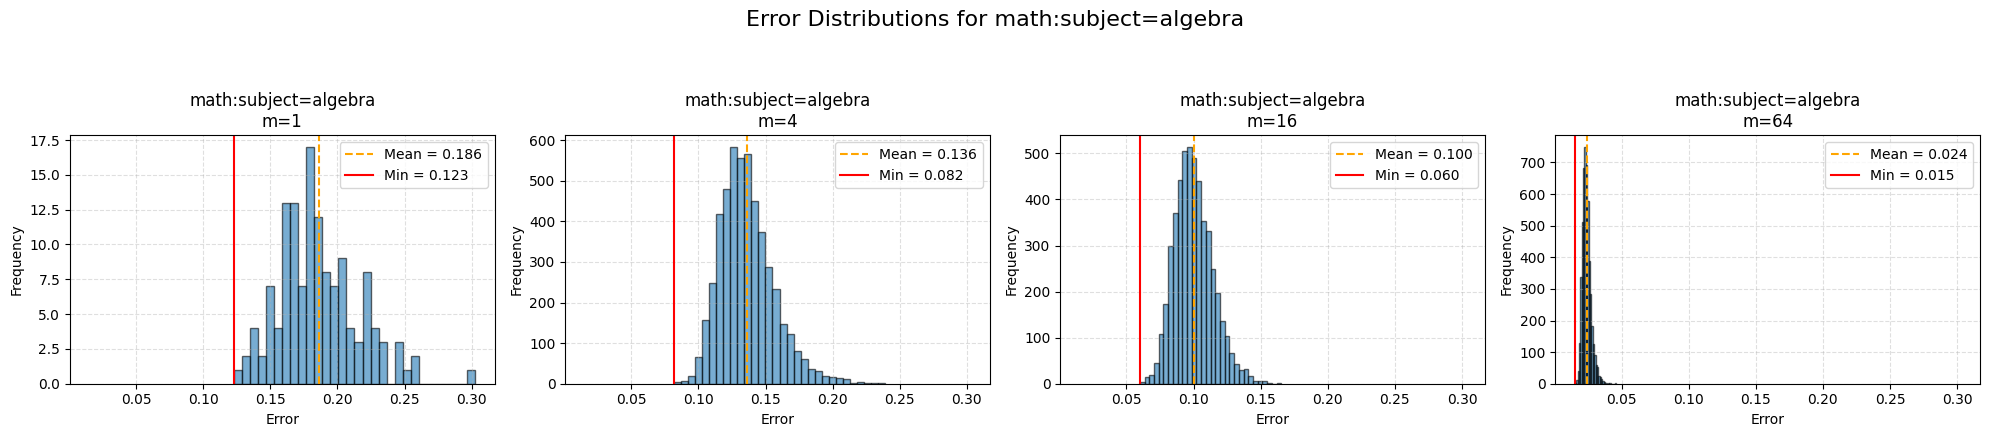

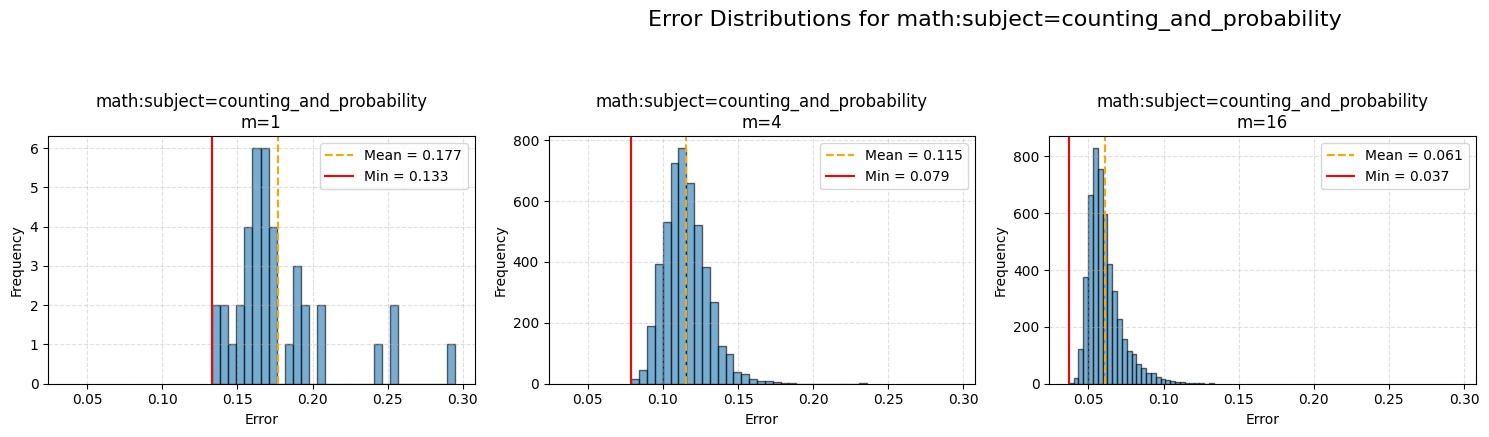

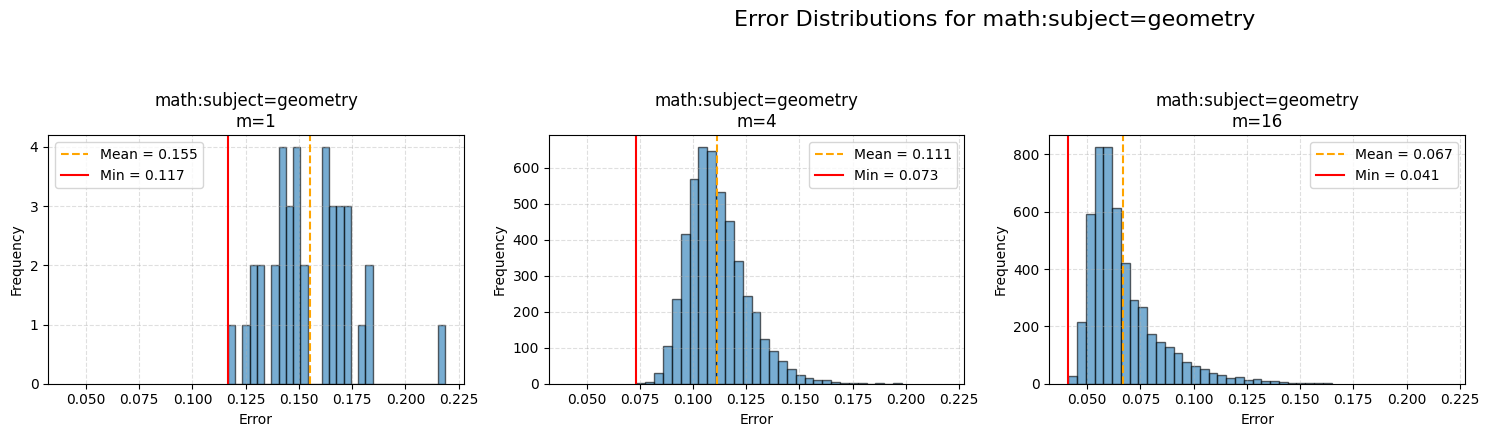

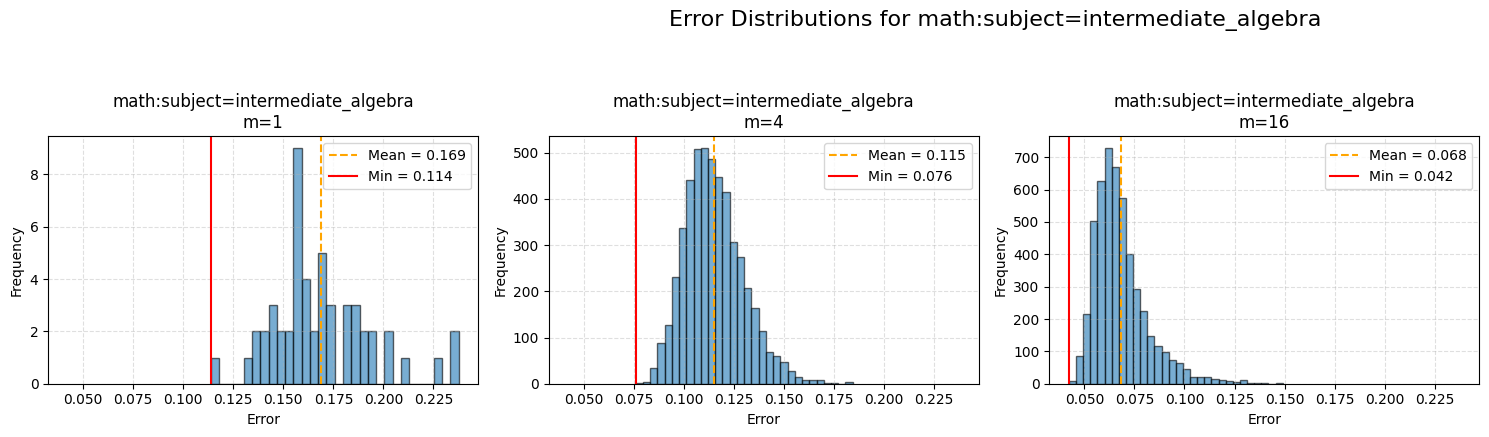

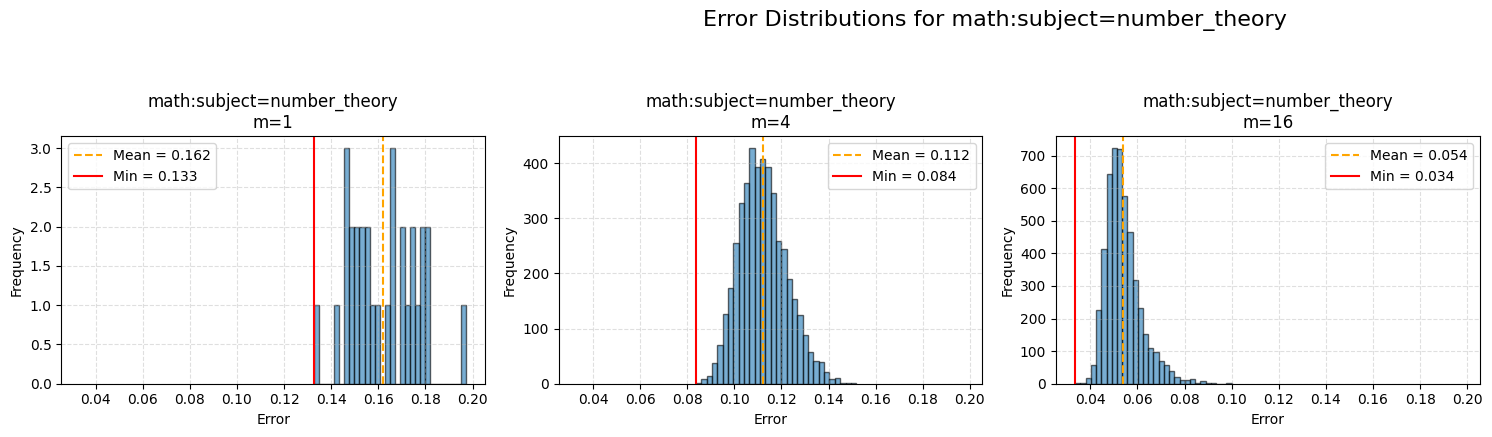

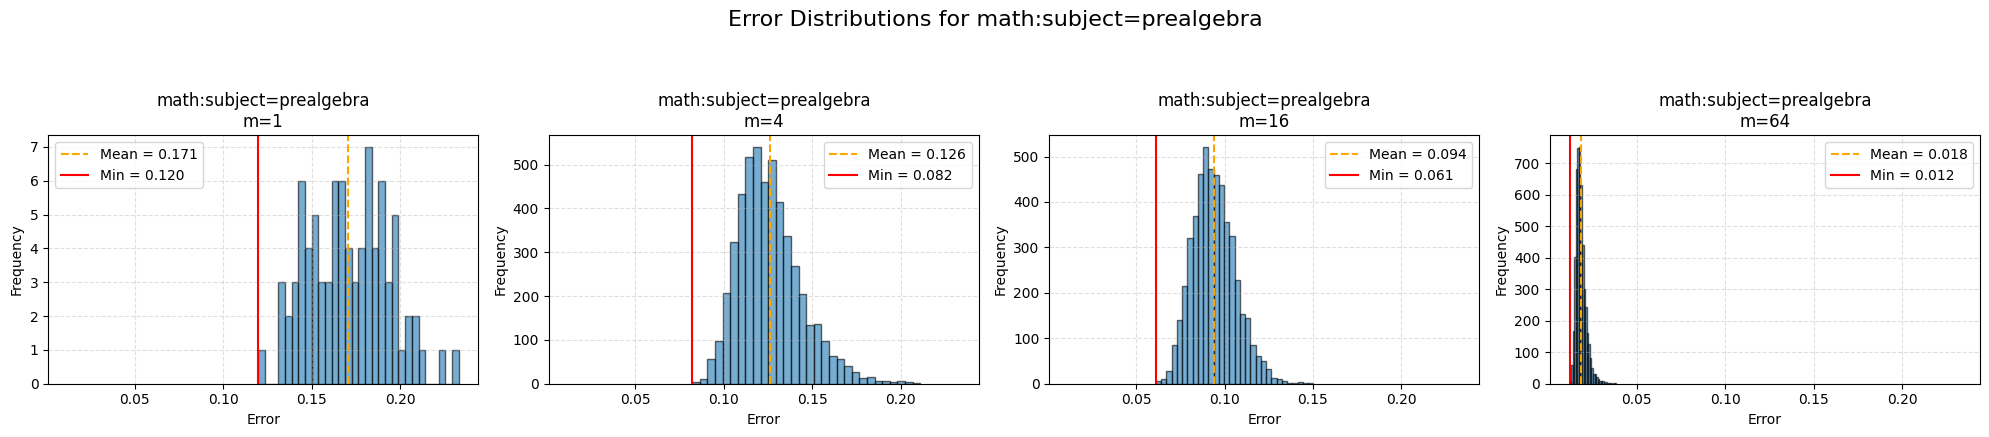

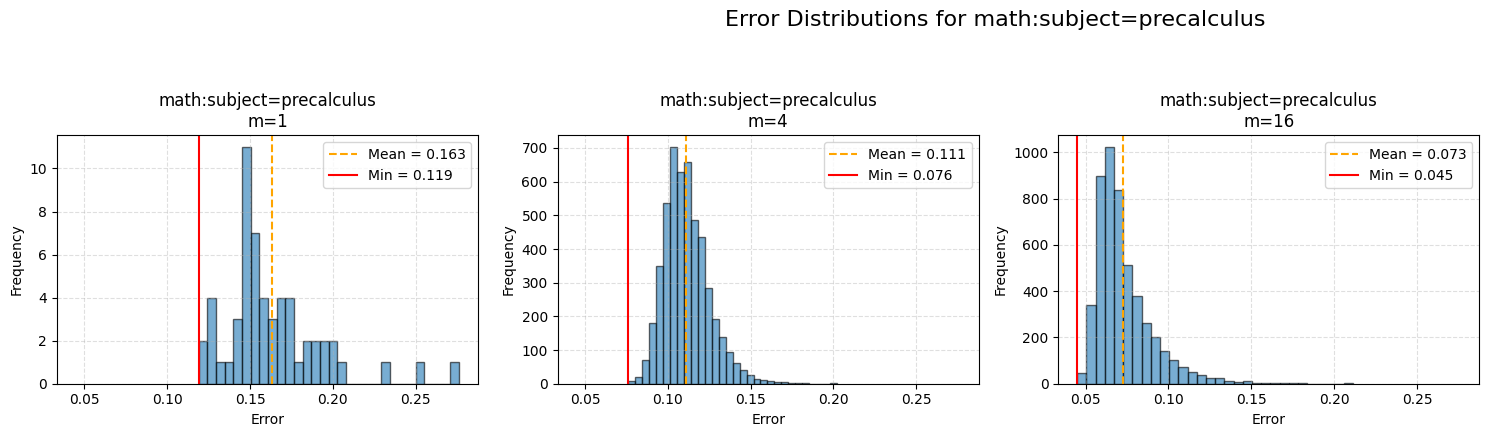

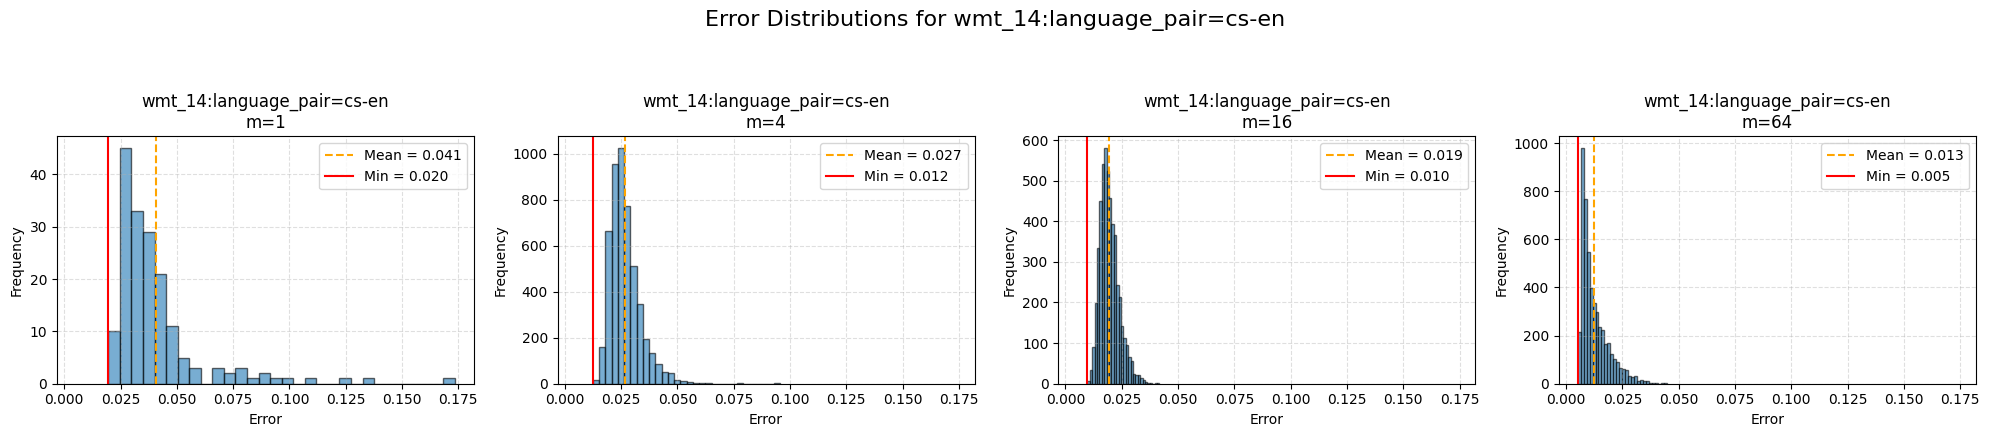

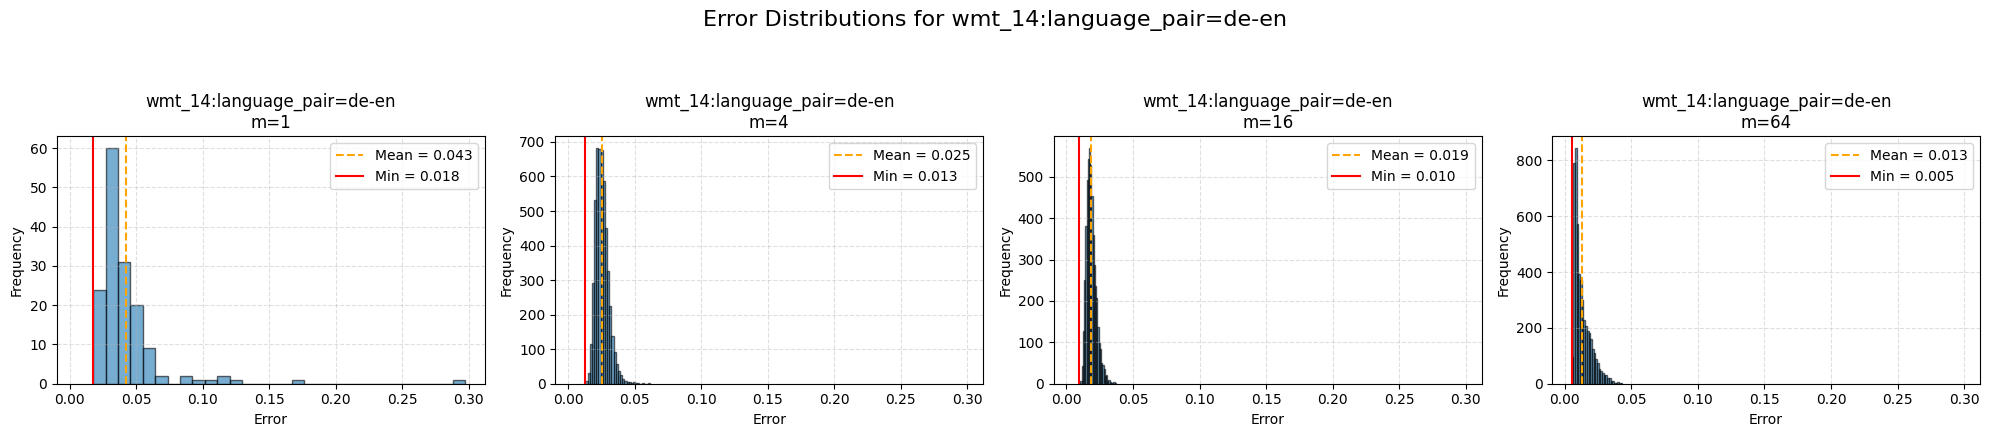

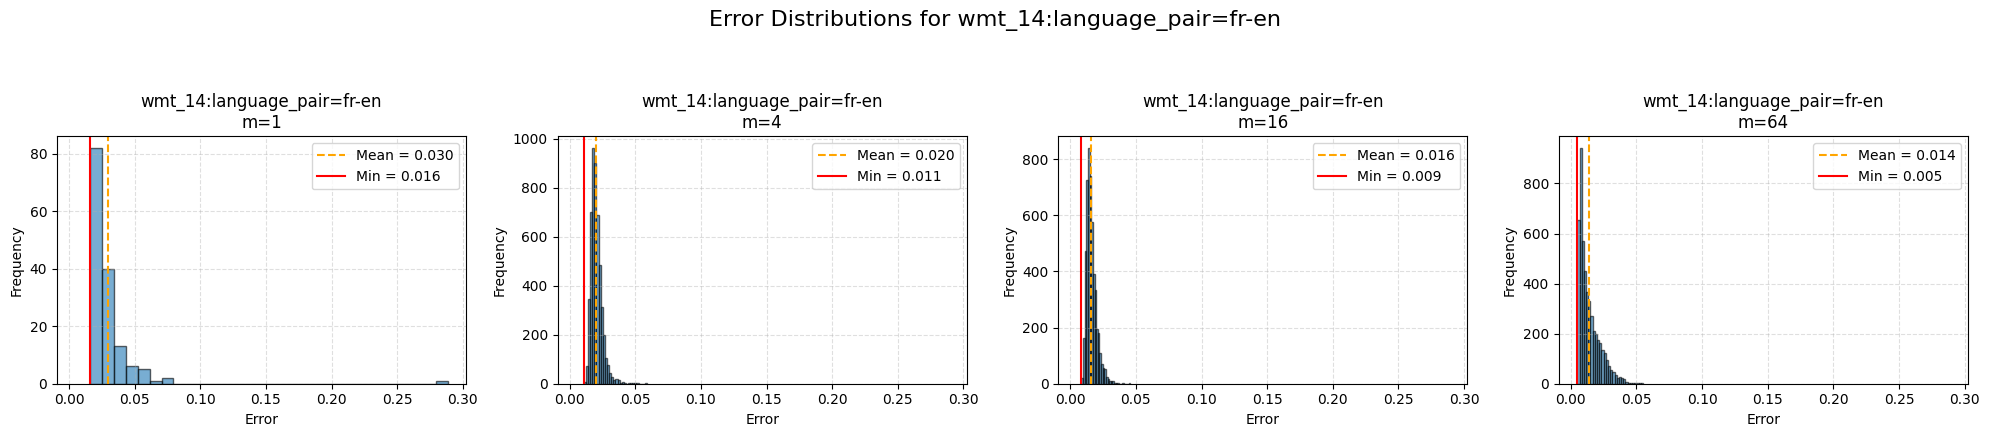

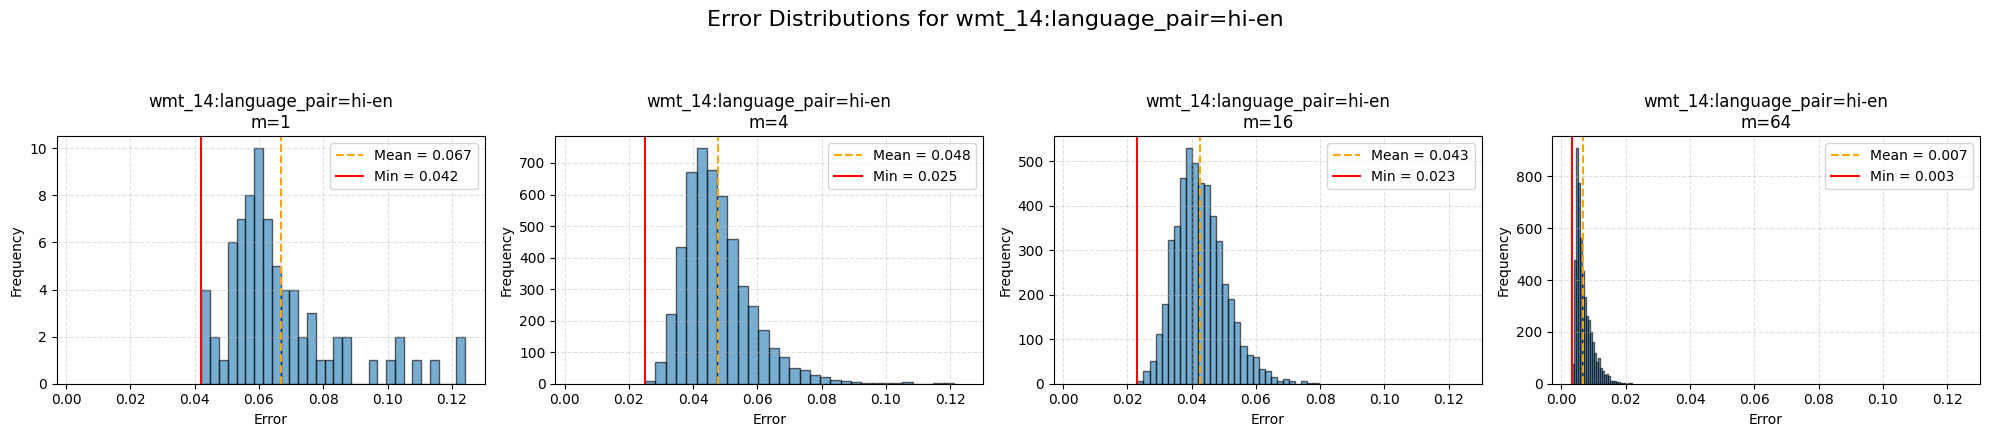

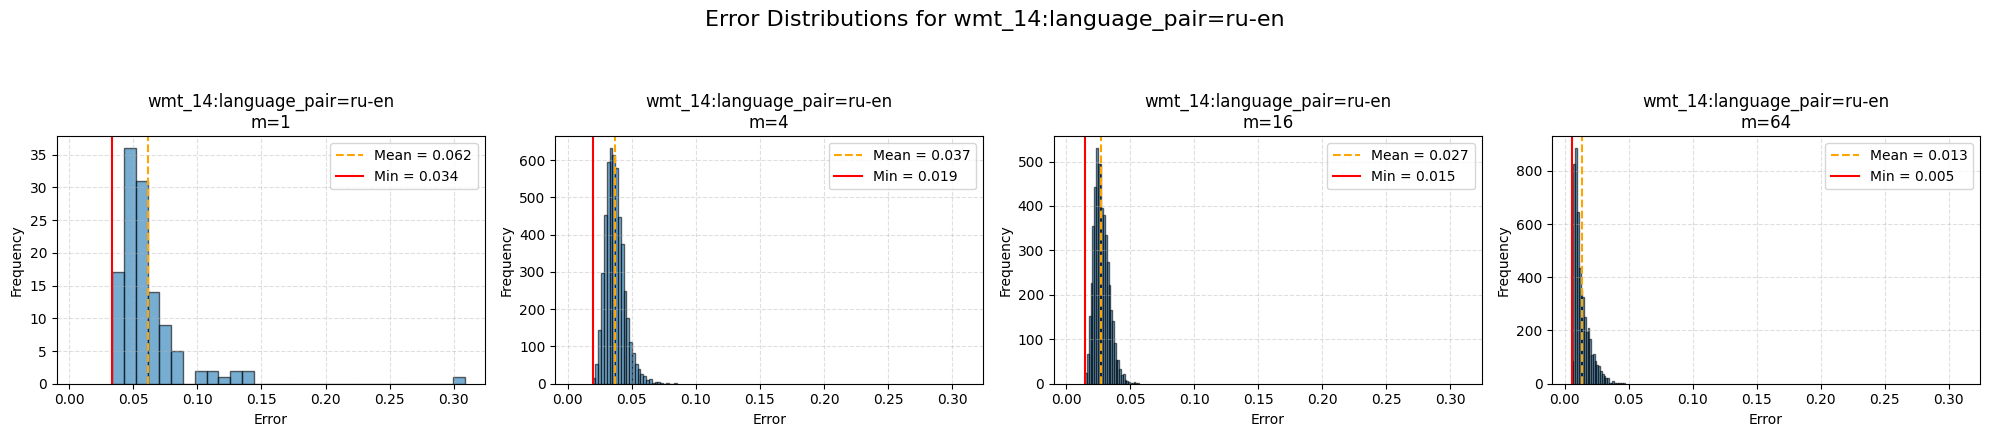

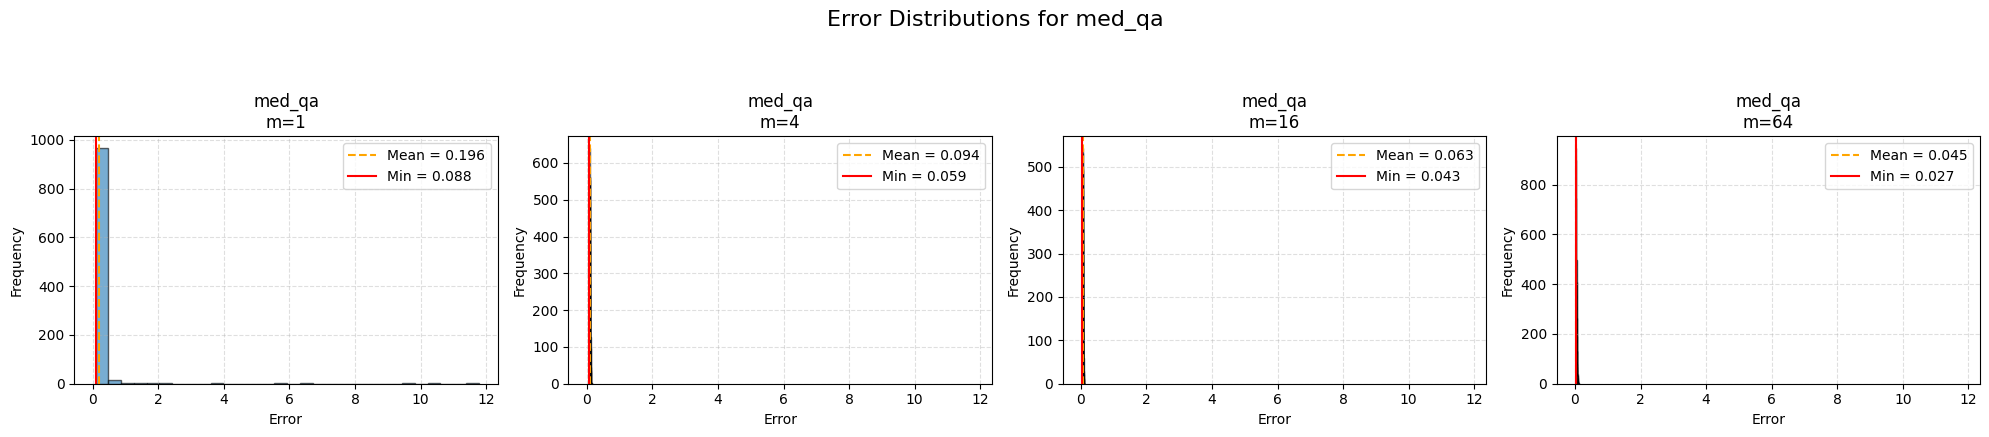

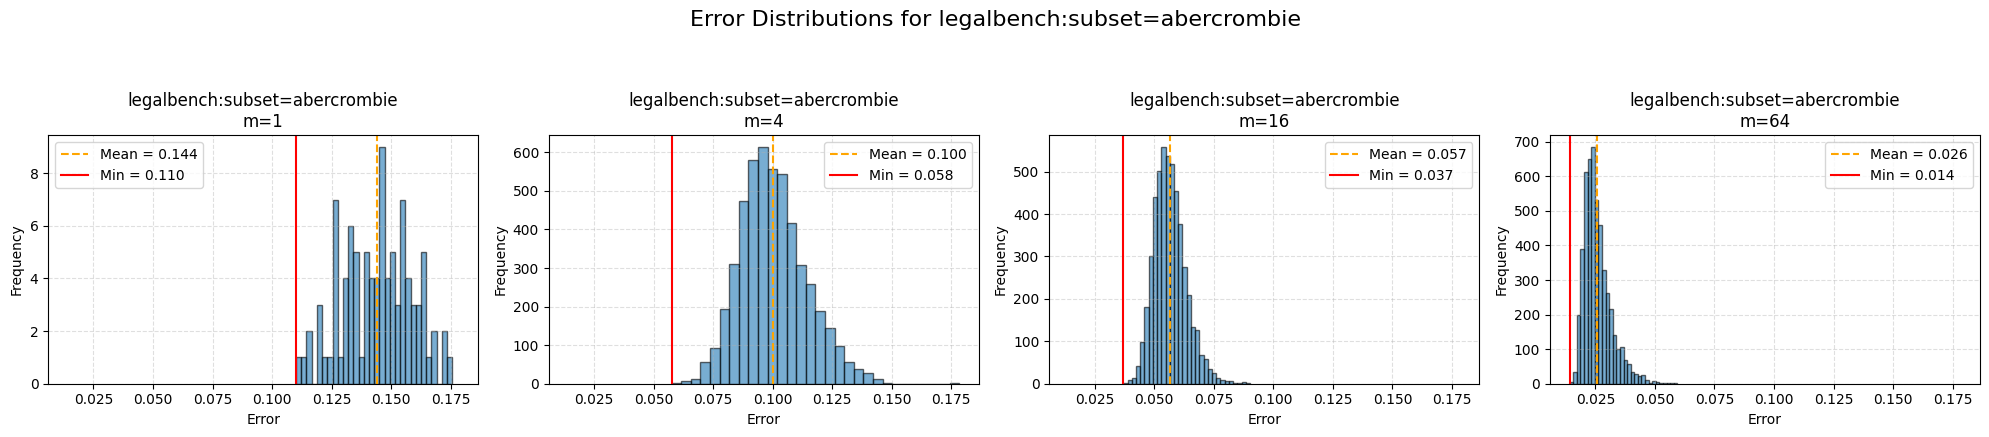

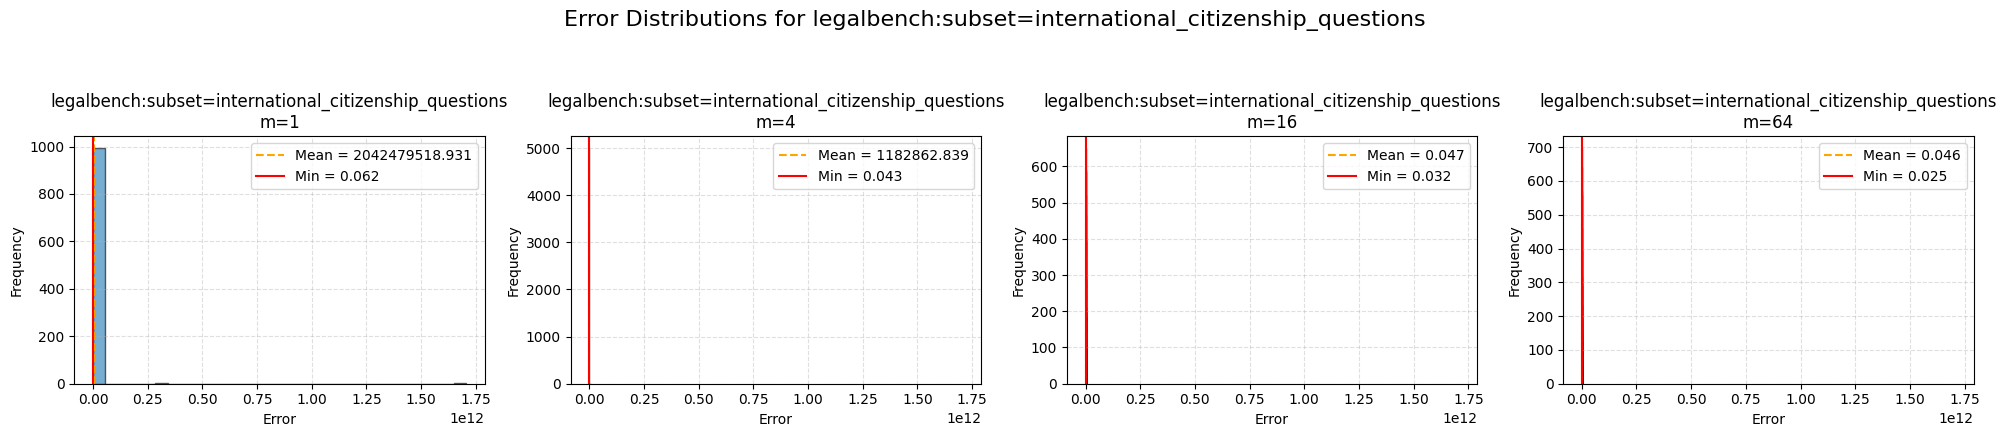

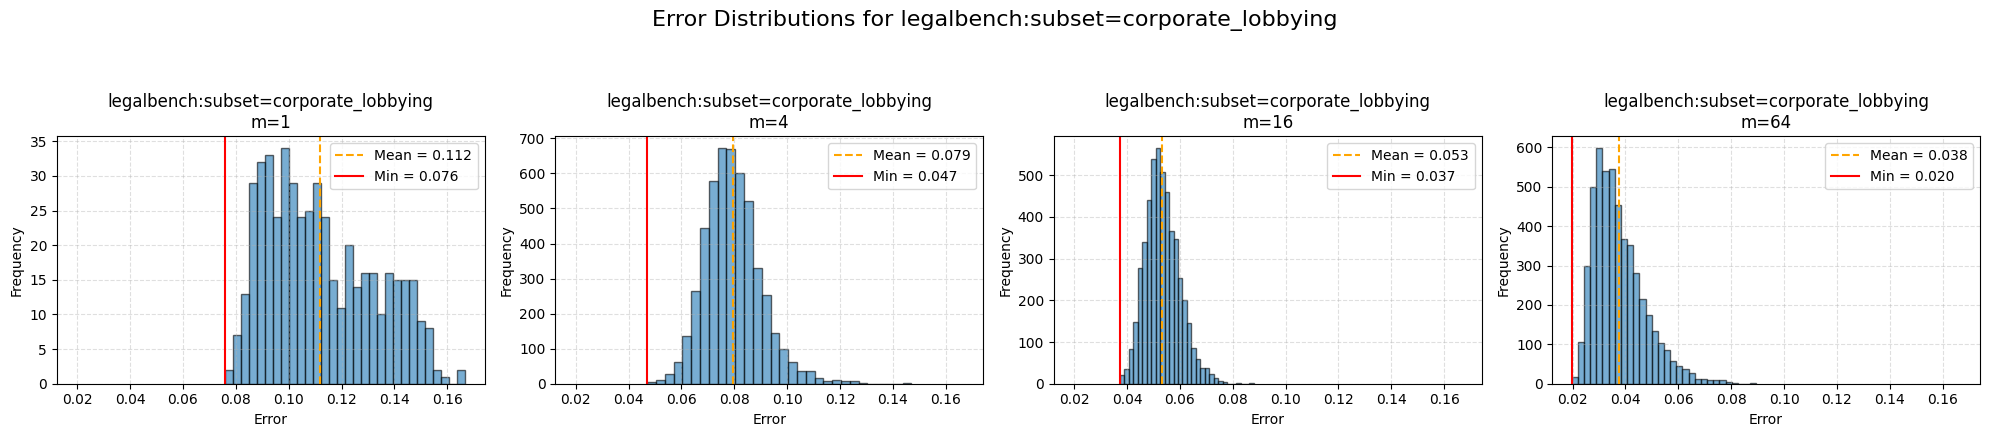

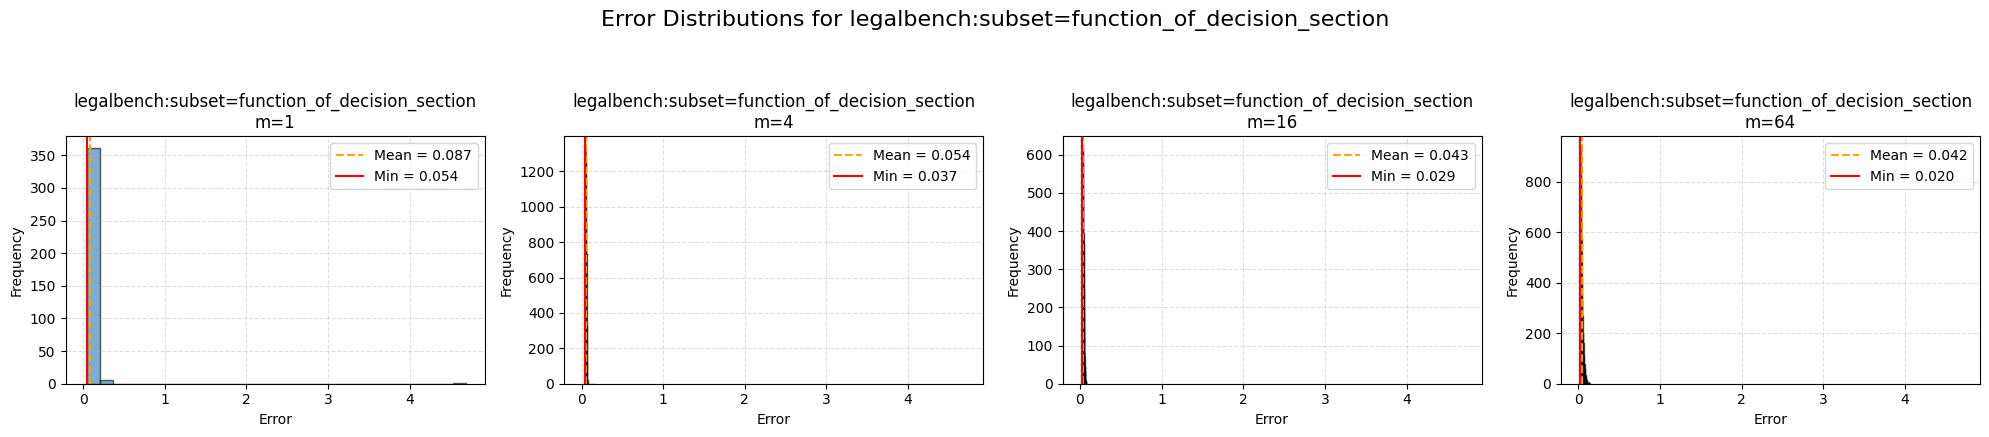

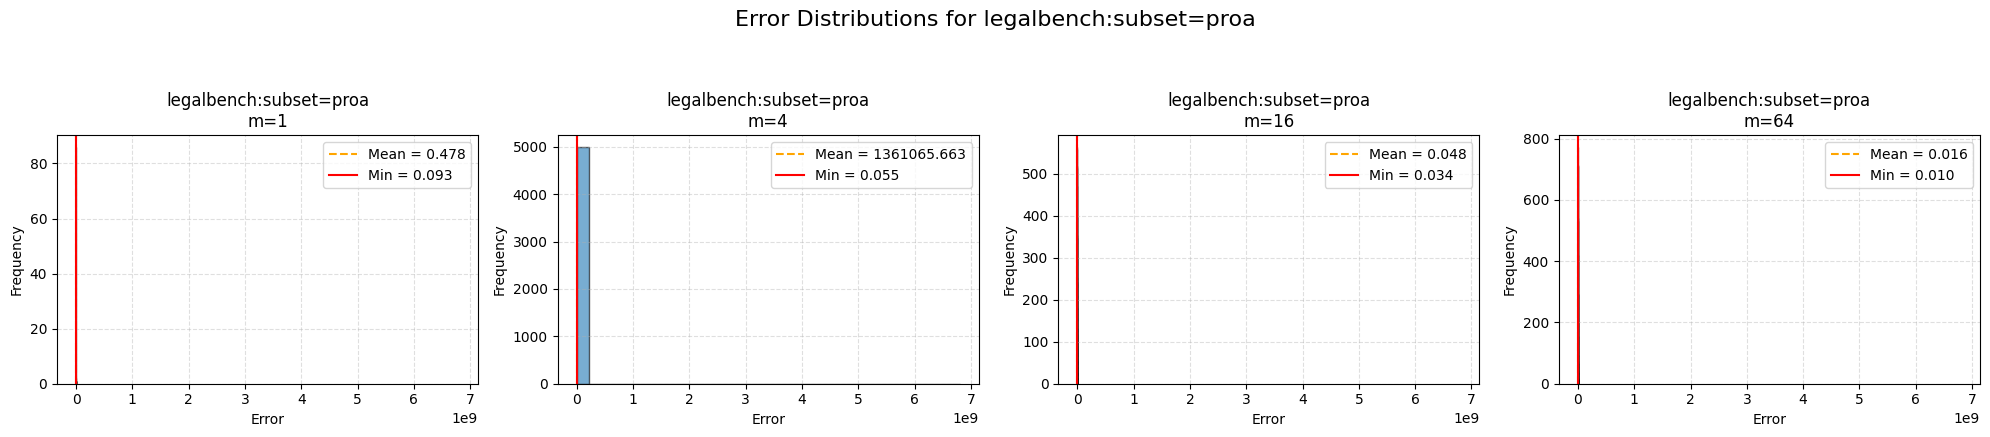

In [14]:
for dataset in instance_id_list_to_error:
    fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharex=True)


    for i, n_sample in enumerate(n_sample_list):
        ax = axes[i]

        # for ax, sample_size in zip(axes, subset_sizes):
        errors = np.array(list(instance_id_list_to_error[dataset][n_sample].values()))
        errors.clip(0,1)

        if len(errors) == 0:
            ax.set_visible(False)
            continue

        median_val = np.mean(errors)
        max_val = np.min(errors)

        # Plot histogram
        ax.hist(errors, bins=30, alpha=0.6, edgecolor='black')
        ax.axvline(median_val, color='orange', linestyle='--', label=f'Mean = {median_val:.3f}')
        ax.axvline(max_val, color='red', linestyle='-', label=f'Min = {max_val:.3f}')

        ax.set_title(f"{dataset}\nm={n_sample}")
        ax.set_xlabel("Error")
        ax.set_ylabel("Frequency")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.4)


        plt.tight_layout()
        plt.suptitle(f"Error Distributions for {dataset}", fontsize=16, y=1.08)

In [58]:
from graspologic.embed import ClassicalMDS as CMDS
from graspologic.cluster import GaussianCluster as GMM
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

tsv_list = ['math.tsv', 'legalbench.tsv', 'med_qa.tsv', 'wmt_14.tsv']

cluster_instance_ids = {dataset: {} for dataset in dataset_dict}
for tsv_string in tsv_list:
    tsv = pd.read_csv('data/' + tsv_string, delimiter='\t')
    split = tsv_string.split('.')[0]

    correct_tsv=True
    for dataset in dataset_dict:
        if split not in dataset:
            continue
        
        query_list = tsv[tsv['dataset'] == dataset]['query'].unique()
        # len(query_list)
        embedded_queries = embedding_model.encode(query_list, normalize_embeddings=True)

        cmds_embds = CMDS().fit_transform(embedded_queries)

        for n_clusters in n_sample_list:
            print(dataset, n_clusters)
            cluster_instance_ids[dataset][n_clusters] = []
            for _ in range(10):
                if n_clusters == 1:
                    labels = np.array([0 for i in range(len(cmds_embds))])
                else:
                    # === 3️⃣ Cluster embeddings
                    kmeans = GMM(min_components=n_clusters, max_components=n_clusters, n_init=10)
                    # kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                    labels = kmeans.fit_predict(cmds_embds)
                cluster_centers_ = np.array([np.mean(cmds_embds[labels == c], axis=0) for c in np.unique(labels)])
            
                # === 4️⃣ Find closest query to each cluster center
                closest_indices, _ = pairwise_distances_argmin_min(cluster_centers_, cmds_embds)
                representative_queries = [query_list[i] for i in closest_indices]
    
                rep_instance_ids = []
                for idx in closest_indices:
                    q = query_list[idx]
                    row = tsv[(tsv['dataset'] == dataset) & (tsv['query'] == q)]
                    rep_instance_ids.append(row['instance_id'].iloc[0])
                cluster_instance_ids[dataset][n_clusters].append(rep_instance_ids)

math:subject=algebra 1
math:subject=algebra 4
math:subject=algebra 16
math:subject=algebra 64
math:subject=counting_and_probability 1
math:subject=counting_and_probability 4
math:subject=counting_and_probability 16
math:subject=counting_and_probability 64
math:subject=geometry 1
math:subject=geometry 4
math:subject=geometry 16
math:subject=geometry 64
math:subject=intermediate_algebra 1
math:subject=intermediate_algebra 4
math:subject=intermediate_algebra 16
math:subject=intermediate_algebra 64
math:subject=number_theory 1
math:subject=number_theory 4
math:subject=number_theory 16
math:subject=number_theory 64
math:subject=prealgebra 1
math:subject=prealgebra 4
math:subject=prealgebra 16
math:subject=prealgebra 64
math:subject=precalculus 1
math:subject=precalculus 4
math:subject=precalculus 16
math:subject=precalculus 64
legalbench:subset=abercrombie 1
legalbench:subset=abercrombie 4
legalbench:subset=abercrombie 16
legalbench:subset=abercrombie 64
legalbench:subset=international_citi

In [63]:
from utils import make_embedding_dict, onehot_embedding
from dkps.embed import embed_api
from dkps.dkps import DataKernelPerspectiveSpace as DKPS

import nest_asyncio
nest_asyncio.apply()

from joblib import delayed, Parallel
from sklearn.linear_model import LinearRegression

def model2family(model):
    return model.split('_')[0]


def predict_null(df, mode='model'):
    """ average score of other models / families """
    assert mode in ['model', 'family']
    
    out = {}
    for model in df.model.unique():
        if mode == 'model':
            sel = df.model != model
        elif mode == 'family':
            sel = df.model.apply(model2family) != model2family(model)
        
        out[model] = df.score[sel].mean()
    
    return out


def _rel_err(act, pred):
    return np.abs(pred - act) / act

def _abs_err(act, pred):
    return np.abs(pred - act)

err_fns = {
    "abs" : _abs_err,
    "rel" : _rel_err,
}

def run_one(df_sample, n_samples, mode, seed, instance_ids):
    out = []
    model_names = df_sample.model.unique()
    
    S_all = df_sample.pivot(index='model', columns='instance_id', values='score').values
    
    embedding_dict = make_embedding_dict(df_sample)
    
    for target_model in model_names:
        
        # split data
        assert mode in ['model', 'family']
        if mode == 'model':
            train_models = np.array([m for m in model_names if m != target_model])
        elif mode == 'family':
            target_family = model2family(target_model)
            train_models  = np.array([m for m in model_names if model2family(m) != target_family])
        
        y_test  = y_acts[target_model]

        # average score over the `n_samples` evaluated
        p_sample = df_sample[df_sample.model == target_model].score.mean()

        # lr on DKPS embeddings of varying dimension
        p_lr_dkps = {}
        for n_components_cmds in [8]:
            for n_models in [len(train_models)]:
                _train_models   = np.random.choice(train_models, size=n_models, replace=False)
                _embedding_dict = {k:embedding_dict[k] for k in (set(_train_models) | set([target_model]))}
                
                P = DKPS(n_components_cmds=n_components_cmds)
                P = P.fit_transform(_embedding_dict, return_dict=True)
                
                _X_train = np.vstack([P[m] for m in _train_models])
                _y_train = np.array([y_acts[m] for m in _train_models])
                _X_test  = np.vstack([P[target_model]])

                # linear regression on DKPS embeddings        
                lr = LinearRegression().fit(_X_train, _y_train)
                
                if n_models != len(train_models):
                    p_lr_dkps[f'p_lr_dkps8__n_components_cmds={n_components_cmds}__n_models={n_models}'] = float(lr.predict(_X_test)[0])
                else:
                    p_lr_dkps[f'p_lr_dkps8__n_components_cmds={n_components_cmds}__n_models=ALL'] = float(lr.predict(_X_test)[0])

        out.append({
            "seed"         : seed,
            "n_samples"    : n_samples,
            "mode"         : mode,
            "target_model" : target_model,
            
            "y_act"        : y_test,
            "p_null"       : pred_null[mode][target_model],
            "p_sample"     : p_sample,

            "instance_ids" : instance_ids,
            
            **p_lr_dkps,
        })
    
    return out



for dataset in dataset_dict:
    print(dataset)
    
    score_col = dataset_dict[dataset]['score_col']
    embed_provider = dataset_dict[dataset]['embed_provider']
    embed_provider = dataset_dict[dataset]['embed_provider']
    embed_model = dataset_dict[dataset]['embed_model']
    err_fn = dataset_dict[dataset]['err_fn']
    outdir=dataset_dict[dataset]['outdir']
    sample = dataset_dict[dataset]['sample']
    seed=dataset_dict[dataset]['seed']
    
    inpath = Path('data') / f'{dataset.split(":")[0]}.tsv'
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    # rprint('[blue]loading data ...[/blue]')

    df = pd.read_csv(inpath, sep='\t')
    df = df[df.dataset == dataset]

    if sample:
        rng           = np.random.default_rng(seed)
        uinstance_ids = df.instance_id.unique()
        keep          = rng.choice(uinstance_ids, int(len(uinstance_ids) * sample), replace=False)
        df            = df[df.instance_id.isin(keep)]

    df = df.sort_values(['model', 'instance_id']).reset_index(drop=True)
    
    if score_col != 'score':
        print(f'{score_col} -> score')
        df['score'] = df[score_col]

    # --
    # QC
    print(f'{len(df.response.unique())} / {df.shape[0]} responses are unique')
    _instance_ids = df.groupby('model').instance_id.apply(list)
    assert all([_instance_ids.iloc[0] == _instance_ids.iloc[i] for i in range(len(_instance_ids))]), 'instance_ids are not the same for each model'
    
    # --
    # Get embeddings
    
    if embed_model == 'onehot':
        df = onehot_embedding(df, dataset=dataset)
    else:
        df['embedding'] = list(embed_api(
            provider   = embed_provider, 
            input_strs = [str(xx) for xx in df.response.values],
            model      = embed_model
        ))
    
    # --
    # Run
    model_names  = df.model.unique()
    instance_ids = df.instance_id.unique()
    y_acts       = df.groupby('model').score.mean().to_dict()

    modes = ['model', 'family']
    pred_null = {mode: predict_null(df, mode=mode) for mode in modes}
    
    # --
    # Simple - DKPS w/ more than one example
    
    outpath = outdir / f'{dataset}-{score_col}-cluster-res.tsv'
    
    jobs = []
    for n_samples in [1, 4, 16, 64]:
        for i,instance_ids_sample in enumerate(cluster_instance_ids[dataset][n_samples]):
            df_sample           = df[df.instance_id.isin(instance_ids_sample)]
            jobs.append(delayed(run_one)(df_sample=df_sample, n_samples=n_samples, mode='family', seed=i, instance_ids=instance_ids_sample))
            
    
    res    = sum(Parallel(n_jobs=-2, verbose=10)(jobs), [])
    df_res = pd.DataFrame(res)
    
    for c in df_res.columns:
        if 'p_' in c:
            df_res[c.replace('p_', 'e_')] = err_fns[err_fn](df_res.y_act, df_res[c])
    
    df_res.to_csv(outpath, sep='\t', index=False)

math:subject=algebra
12045 / 12825 responses are unique


Embedding chunks: 100%|█████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 2096.29it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    1.8s remaining:   10.0s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    2.2s remaining:    5.8s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    2.5s remaining:    3.7s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    4.0s remaining:    3.6s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    4.9s remaining:    2.6s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:   12.8s remaining:    3.7s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:   14.7s remaining:    1.6s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:   16.3s finished


math:subject=counting_and_probability
3537 / 3705 responses are unique


Embedding chunks: 100%|████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 154.21it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.5s remaining:    3.0s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    2.5s remaining:    2.2s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    3.1s remaining:    1.7s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    6.4s remaining:    1.8s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    7.1s remaining:    0.8s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    7.7s finished


math:subject=geometry
3436 / 3610 responses are unique


Embedding chunks: 100%|████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 155.63it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.5s remaining:    3.1s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    1.2s remaining:    3.1s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    3.3s remaining:    2.9s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    3.7s remaining:    2.0s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    8.7s remaining:    2.5s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    9.1s remaining:    1.0s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    9.6s finished


math:subject=intermediate_algebra
4563 / 4940 responses are unique


Embedding chunks: 100%|████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 154.02it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.5s remaining:    3.1s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    3.9s remaining:    3.5s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    4.4s remaining:    2.4s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    9.6s remaining:    2.8s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:   11.5s remaining:    1.3s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:   12.8s finished


math:subject=number_theory
2693 / 2850 responses are unique


Embedding chunks: 100%|████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 125.84it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.5s remaining:    3.0s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    1.2s remaining:    3.1s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    2.8s remaining:    2.6s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    3.7s remaining:    2.0s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    6.3s remaining:    1.8s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    7.0s remaining:    0.8s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    7.3s finished


math:subject=prealgebra
7690 / 8170 responses are unique


Embedding chunks: 100%|██████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 168.95it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.5s remaining:    3.0s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.9s remaining:    2.5s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    2.6s remaining:    2.3s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    2.9s remaining:    1.6s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    7.1s remaining:    2.1s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    8.1s remaining:    0.9s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    9.4s finished


math:subject=precalculus
4598 / 5415 responses are unique


Embedding chunks: 100%|██████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 163.03it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.5s remaining:    3.0s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    3.6s remaining:    3.3s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    4.1s remaining:    2.2s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    9.5s remaining:    2.8s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:   10.6s remaining:    1.2s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:   11.0s finished


wmt_14:language_pair=cs-en
meteor -> score
12159 / 16530 responses are unique


Embedding chunks: 100%|██████████████████████████████████████████████████████████████| 331/331 [00:01<00:00, 226.61it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.03382515907287598s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.5s remaining:    2.9s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    2.2s remaining:    0.7s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    3.3s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    4.2s finished


wmt_14:language_pair=de-en
meteor -> score
9248 / 14725 responses are unique


Embedding chunks: 100%|██████████████████████████████████████████████████████████████| 295/295 [00:01<00:00, 226.78it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.011722087860107422s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    1.5s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    2.8s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    3.3s finished


wmt_14:language_pair=fr-en
meteor -> score
8495 / 14100 responses are unique


Embedding chunks: 100%|██████████████████████████████████████████████████████████████| 282/282 [00:01<00:00, 205.71it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.00709843635559082s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    3.3s finished


wmt_14:language_pair=hi-en
meteor -> score
6224 / 7315 responses are unique


Embedding chunks: 100%|██████████████████████████████████████████████████████████████| 147/147 [00:00<00:00, 211.27it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.006644487380981445s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    2.5s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    3.4s finished


wmt_14:language_pair=ru-en
meteor -> score
8102 / 11590 responses are unique


Embedding chunks: 100%|██████████████████████████████████████████████████████████████| 232/232 [00:01<00:00, 224.74it/s]
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Batch computation too fast (0.041777610778808594s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.5s remaining:    1.3s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    1.5s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    3.0s finished


med_qa
21 / 95000 responses are unique


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    0.9s finished


legalbench:subset=abercrombie
6 / 8835 responses are unique


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    0.8s finished


legalbench:subset=international_citizenship_questions
3 / 93000 responses are unique


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.9s remaining:    0.8s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    1.3s finished


legalbench:subset=corporate_lobbying
3 / 45570 responses are unique


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.4s remaining:    2.0s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    2.2s finished


legalbench:subset=function_of_decision_section
8 / 34131 responses are unique


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    0.9s finished


legalbench:subset=proa
3 / 8835 responses are unique


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-2)]: Done  1 out of 40 | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done  6 out of 40 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=-2)]: Done 11 out of 40 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-2)]: Done 16 out of 40 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-2)]: Done 21 out of 40 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 26 out of 40 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-2)]: Done 31 out of 40 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 36 out of 40 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done 40 out of 40 | elapsed:    0.8s finished


In [65]:
df_res = pd.read_csv(outpath, delimiter='\t')
df_res

,seed,n_samples,mode,target_model,y_act,p_null,p_sample,instance_ids,p_lr_dkps8__n_components_cmds=8__n_models=ALL,e_null,e_sample,e_lr_dkps8__n_components_cmds=8__n_models=ALL
0,0,1,family,01-ai_yi-34b,0.800000,0.854737,1.000000,['legalbench:subset=proa--id49'],0.839143,0.054737,0.200000,0.039143
1,0,1,family,01-ai_yi-6b,0.778947,0.854737,0.000000,['legalbench:subset=proa--id49'],0.839857,0.075789,0.778947,0.060910
2,0,1,family,01-ai_yi-large-preview,0.884211,0.854737,1.000000,['legalbench:subset=proa--id49'],0.869471,0.029474,0.115789,0.014740
3,0,1,family,AlephAlpha_luminous-base,0.505263,0.860936,1.000000,['legalbench:subset=proa--id49'],0.894973,0.355673,0.494737,0.389710
4,0,1,family,AlephAlpha_luminous-extended,0.631579,0.860936,0.000000,['legalbench:subset=proa--id49'],0.785029,0.229357,0.631579,0.153450
...,...,...,...,...,...,...,...,...,...,...,...,...
3715,9,64,family,tiiuae_falcon-7b,0.557895,0.858184,0.500000,"['legalbench:subset=proa--id68', 'legalbench:s...",0.409540,0.300289,0.057895,0.148355
3716,9,64,family,upstage_solar-pro-241126,0.905263,0.853089,0.928571,"['legalbench:subset=proa--id68', 'legalbench:s...",0.921586,0.052174,0.023308,0.016323
3717,9,64,family,writer_palmyra-x-004,0.989474,0.849825,1.000000,"['legalbench:subset=proa--id68', 'legalbench:s...",0.956848,0.139649,0.010526,0.032625
3718,9,64,family,writer_palmyra-x-v2,0.989474,0.849825,1.000000,"['legalbench:subset=proa--id68', 'legalbench:s...",0.956849,0.139649,0.010526,0.032625
